In [1]:
import sys
import os
import numpy as np
import xarray as xr
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.metrics import brier_score_loss
from sklearn.linear_model import LogisticRegression

sys.path.append(os.path.expanduser('~/Documents/Hybrid/'))
from Hybrid.neuralnet import construct_modeldev_model, earlystop, BrierScore, ConstructorAndCompiler
from Hybrid.dataprep import test_trainval_split, multiclass_log_forecastprob, singleclass_regression, multiclass_logistic_regression_coefficients, scale_other_features
from Hybrid.interpretation import combine_input_output, composite_extremes, order_by_hierachical_clustering, gradient

crossval = True # Only for the trainvalsplit.
nfolds = 3
balanced = True
focus_class = -1 # Index of the class to be scored and benchmarked through bss

name = 'tg-anom_JJA_45r1_31D-roll-mean_q05_sep12-15'
#name = 'tg-ex-q0.75-21D_ge7D_sep12-15'

predictor_dir = Path('/nobackup/users/straaten/predsets/objective_balanced_cv/') # Can change to the objectively selected sets
for_obs_dir = Path('/nobackup/users/straaten/predsets/full/') 

predictors = pd.read_hdf(predictor_dir / f'{name}_multi_d20_b3_predictors.h5', key = 'input').iloc[:,:4]
forc = pd.read_hdf(for_obs_dir / f'{name}_forc.h5', key = 'input')
obs= pd.read_hdf(for_obs_dir / f'{name}_obs.h5', key = 'target')

2021-12-16 15:55:33.592148: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-16 15:55:33.592169: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Splitting the sets.
X_test, X_trainval, generator = test_trainval_split(predictors, crossval = crossval, nfolds = nfolds, balanced = balanced)
forc_test, forc_trainval, generator = test_trainval_split(forc, crossval = crossval, nfolds = nfolds, balanced = balanced)
obs_test, obs_trainval, generator = test_trainval_split(obs, crossval = crossval, nfolds = nfolds, balanced = balanced)

# Prepare trainval data for the neural network
features_trainval, feature_scaler = scale_other_features(X_trainval)
logforc_trainval = multiclass_log_forecastprob(forc_trainval)
obsinp_trainval = obs_trainval.values

# Preparing the test set
features_test, _ = scale_other_features(X_test, fitted_scaler=feature_scaler)
logforc_test = multiclass_log_forecastprob(forc_test)

fitting a new feature scaler
using a pre-fitted feature scaler


In [4]:
# Setting up the model
construct_kwargs = dict(n_classes = obs_trainval.shape[-1],
        n_hidden_layers= 1,
        n_features = features_trainval.shape[-1],
        n_hiddenlayer_nodes = 4)

compile_kwargs = dict(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0014),
        metrics = ['accuracy',BrierScore(class_index = focus_class)])

constructor = ConstructorAndCompiler(construct_modeldev_model, construct_kwargs, compile_kwargs)

fit_kwargs = dict(batch_size = 32, epochs = 200, shuffle = True, callbacks = [earlystop(patience = 7, monitor = 'val_loss')])

2021-12-16 15:55:51.675642: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-16 15:55:51.675668: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-16 15:55:51.675692: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pc160104): /proc/driver/nvidia/version does not exist
2021-12-16 15:55:51.675896: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Training the model and generating predictions
model = constructor.fresh_model()
model.fit(x = [features_trainval, logforc_trainval], y=obsinp_trainval, validation_split = 0.33, **fit_kwargs)

preds_test = model.predict(x = [features_test, logforc_test])
preds_trainval = model.predict(x = [features_trainval, logforc_trainval])

2021-12-16 15:55:58.343243: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-16 15:55:58.355388: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3591775000 Hz


Epoch 1/200
41/41 [==============================] - 0s 4ms/step - loss: 0.7263 - accuracy: 0.5498 - brier: 0.2599 - val_loss: 0.7864 - val_accuracy: 0.4826 - val_brier: 0.2893
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.7233 - accuracy: 0.5498 - brier: 0.2584 - val_loss: 0.7842 - val_accuracy: 0.4826 - val_brier: 0.2885
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.7185 - accuracy: 0.5894 - brier: 0.2559 - val_loss: 0.7798 - val_accuracy: 0.4937 - val_brier: 0.2868
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.7105 - accuracy: 0.5980 - brier: 0.2522 - val_loss: 0.7750 - val_accuracy: 0.4874 - val_brier: 0.2847
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6994 - accuracy: 0.5980 - brier: 0.2471 - val_loss: 0.7678 - val_accuracy: 0.5032 - val_brier: 0.2817
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6852 - accuracy: 0.6011 - brier: 0.2406 

41/41 [==============================] - 0s 1ms/step - loss: 0.5324 - accuracy: 0.7574 - brier: 0.1701 - val_loss: 0.6254 - val_accuracy: 0.6293 - val_brier: 0.2195
Epoch 48/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5327 - accuracy: 0.7582 - brier: 0.1700 - val_loss: 0.6248 - val_accuracy: 0.6293 - val_brier: 0.2193
Epoch 49/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5327 - accuracy: 0.7589 - brier: 0.1703 - val_loss: 0.6284 - val_accuracy: 0.6388 - val_brier: 0.2204
Epoch 50/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5340 - accuracy: 0.7621 - brier: 0.1705 - val_loss: 0.6213 - val_accuracy: 0.6325 - val_brier: 0.2184
Epoch 51/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5335 - accuracy: 0.7551 - brier: 0.1703 - val_loss: 0.6227 - val_accuracy: 0.6325 - val_brier: 0.2186
Epoch 52/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5315 - accuracy: 0.7558 - brier: 0.1697 - val_l

In [24]:
# Gathering outputs
outpos = combine_input_output(model = model, feature_inputs = np.concatenate([features_trainval,features_test]), 
                              log_of_raw = np.concatenate([logforc_trainval,logforc_test]), target_class_index = -1, 
                              feature_names = X_trainval.columns.to_flat_index(), index = X_trainval.index.append(X_test.index))
outneg = combine_input_output(model = model, feature_inputs = np.concatenate([features_trainval,features_test]), 
                              log_of_raw = np.concatenate([logforc_trainval,logforc_test]), target_class_index = 0, 
                              feature_names = X_trainval.columns.to_flat_index(), index = X_trainval.index.append(X_test.index))
outpos['realchange'] = outpos['f_cor']/outpos['f_raw']
outneg['realchange'] = outneg['f_cor']/outneg['f_raw']

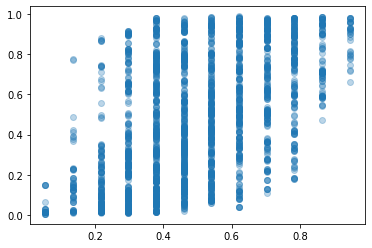

In [26]:
plt.scatter(outpos['f_raw'], outpos['f_cor'], alpha = 0.3) # The amount of change is less at the tails (already certain)

* Changes to f_raw are least present at the extremes (1,0). Inbetween a lot is possible.

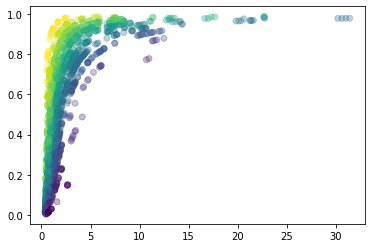

In [27]:
plt.scatter(outpos['multi'], outpos['f_cor'], c = outpos['f_raw'], alpha = 0.3) # Lines come from the raw (discrete) forecast values.

* Large multiplications (e.g. > 3) are usually also associated to larger corrected probabilities. However, not neccesarily the case when one starts with a low f_raw.

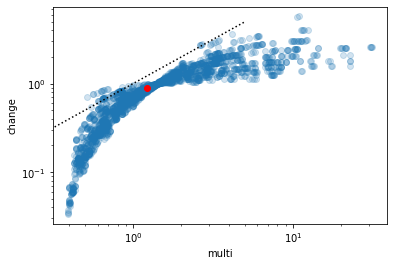

In [28]:
plt.scatter(outpos['multi'], outpos['realchange'], alpha = 0.2)
plt.plot([0,5],[0,5], ls = ':', color = 'black')
plt.scatter(outpos['multi'].median(), outpos['realchange'].median(), color = 'red')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('multi')
plt.ylabel('change')
plt.show()

* Especially multiplications below 1 lead to a reduction that is larger (probably because the negative class is scaled up heavily). The general pattern for this target is also an overall decrease of the positive class because it is overforecast.
* Same curve is present for the negative class (because of course there is a limit to multiplications >1.)

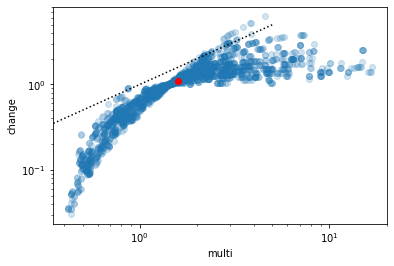

In [29]:
plt.scatter(outneg['multi'], outneg['realchange'], alpha = 0.2)
plt.plot([0,5],[0,5], ls = ':', color = 'black')
plt.scatter(outneg['multi'].median(), outneg['realchange'].median(), color = 'red')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('multi')
plt.ylabel('change')
plt.show()

<AxesSubplot:xlabel='time'>

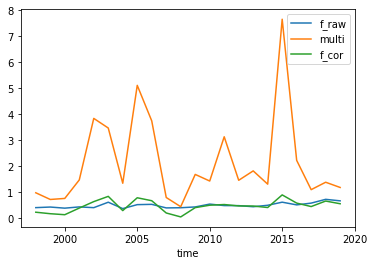

In [30]:
outpos[['f_raw','multi','f_cor']].groupby(outpos.index.get_level_values('time').year).mean().plot()

In [31]:
# Correlation matrices. Which predictors correlate best with the corrections?
# Perhaps linear correlation is not the best, as we have a non-linear method.
from scipy.stats import spearmanr

In [32]:
pearson = np.corrcoef(outpos.values.T)
spearman = spearmanr(outpos.values, axis = 0)[0]
with_multi = pd.DataFrame({'pearson':pearson[1,:],'spearman':spearman[1,:]}, index = outpos.columns)
with_raw = pd.DataFrame({'pearson':pearson[0,:],'spearman':spearman[0,:]}, index = outpos.columns)
#plt.imshow(cormat)

In [33]:
pearson = np.corrcoef(outneg.values.T)
spearman = spearmanr(outneg.values, axis = 0)[0]
with_multi_neg = pd.DataFrame({'pearson':pearson[1,:],'spearman':spearman[1,:]}, index = outneg.columns)
with_raw_neg = pd.DataFrame({'pearson':pearson[0,:],'spearman':spearman[0,:]}, index = outneg.columns)

In [34]:
pd.concat([with_multi,with_multi_neg], axis = 1, keys = ['pos','neg'])

pos                 neg          
                                  pearson  spearman   pearson  spearman
f_raw                           -0.034737  0.026993  0.075839  0.020719
multi                            1.000000  1.000000  1.000000  1.000000
f_cor                            0.596540  0.847647  0.640901  0.843685
(sst_nhplus, 21, 4, spatcov)     0.448440  0.667724 -0.597258 -0.656219
(sst, 21, 3, mean)              -0.273448 -0.150633  0.156214  0.162676
(t850_nhblock, 21, 0, mean)      0.337232  0.351268 -0.306059 -0.343066
(swvl13_europe, 11, 0, spatcov) -0.278256 -0.344322  0.262106  0.360383
realchange                       0.688208  0.972381  0.581913  0.936959

In [35]:
pd.concat([with_multi,with_raw], axis = 1, keys = ['multi','raw']).loc[:,(slice(None),'spearman')]

,multi,raw
,spearman,spearman
f_raw,0.026993,1.000000
multi,1.000000,0.026993
f_cor,0.847647,0.506184
"(sst_nhplus, 21, 4, spatcov)",0.667724,0.224952
"(sst, 21, 3, mean)",-0.150633,0.333485
"(t850_nhblock, 21, 0, mean)",0.351268,0.093067
"(swvl13_europe, 11, 0, spatcov)",-0.344322,0.111409
realchange,0.972381,0.026627


* So it is interesting that there are variables with a different relation to the correction than the the raw forecast probability. This means that they are not just used for negative moderation (lowering when values are high, heightening when values are low). SSt and swvl13 are such examples.
* It can also be concluded that the variables actually have weak links to the raw forecast probabilities (and presumably also to the observation).
* The fact that the first strong factor is really related to the multi and less (but still positive) to the raw values, might indicate that this is an underexpressed link.

In [38]:
# Composites for extreme corrections.

In [39]:
composite_extremes(outpos,level = 0.1)

,0.1,neutral,0.9
f_raw,0.449858,0.506519,0.491821
multi,0.464194,1.546279,9.067288
f_cor,0.077814,0.474271,0.918585
"(sst_nhplus, 21, 4, spatcov)",0.223533,0.477371,0.655079
"(sst, 21, 3, mean)",0.417695,0.421577,0.255931
"(t850_nhblock, 21, 0, mean)",0.346093,0.457184,0.575217
"(swvl13_europe, 11, 0, spatcov)",0.666638,0.546049,0.420815
realchange,0.150141,0.950989,2.094103


In [40]:
composite_extremes(outpos, columnname = 'f_raw', level = 0.1)

,0.1,neutral,0.9
f_raw,0.177731,0.510644,0.886443
multi,1.712755,2.290917,1.498322
f_cor,0.183649,0.491418,0.803839
"(sst_nhplus, 21, 4, spatcov)",0.409245,0.470057,0.570515
"(sst, 21, 3, mean)",0.330681,0.402452,0.566748
"(t850_nhblock, 21, 0, mean)",0.411863,0.461074,0.488683
"(swvl13_europe, 11, 0, spatcov)",0.545610,0.539634,0.638182
realchange,1.033436,0.985011,0.906221


* The changing scales, sometimes opposite signs make me think about the association direction in scatterplots. A factor usually associated with higher probabilities, need not be in the same way be associated to overforcasting.
* plus isn't it possible to show the bivariate plot (combination of empirical factors leading to higher) for raw probabilities, and to show the same for with heightened corrected probabilities?

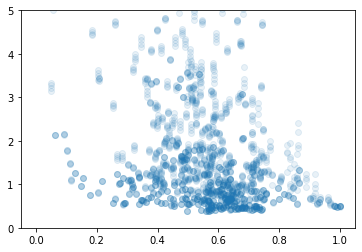

In [46]:
fig, ax = plt.subplots()
ax.scatter(outpos[('swvl13_europe', 11, 0, 'spatcov')], outpos['multi'], alpha = 0.1)
ax.set_ylim(0,5)
plt.show()

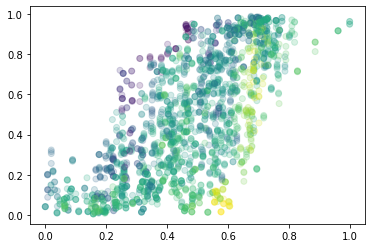

In [50]:
plt.scatter(outpos[('sst_nhplus', 21, 4, 'spatcov')], outpos['f_cor'], alpha = 0.2, c = outpos[('swvl13_europe', 11, 0, 'spatcov')])

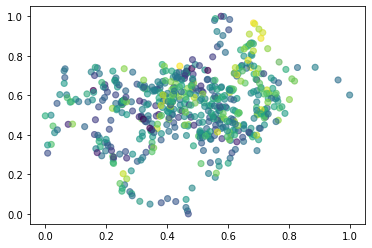

In [48]:
plt.scatter(outpos[('sst_nhplus', 21, 4, 'spatcov')],outpos[('swvl13_europe', 11, 0, 'spatcov')], alpha = 0.2, c = outpos[('f_raw')])

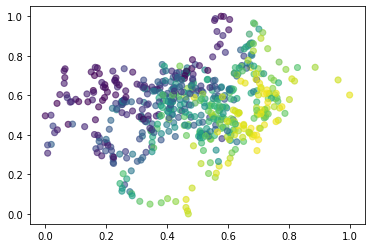

In [49]:
plt.scatter(outpos[('sst_nhplus', 21, 4, 'spatcov')],outpos[('swvl13_europe', 11, 0, 'spatcov')], alpha = 0.2, c = outpos[('f_cor')])

### Explanation of situations.